In [434]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams

from discretize import TensorMesh
from pymatsolver import Pardiso

from SimPEG import maps, SolverLU, utils
from SimPEG.electromagnetics.static import resistivity as DC
from SimPEG.maps import IdentityMap
from SimPEG.electromagnetics.static.utils import static_utils

In [435]:
# Mesh parameters
npad = 20
cs = 0.5
hx = [(cs, npad, -1.3), (cs, 81), (cs, npad, 1.3)]
hy = [(cs, npad, -1.3), (cs, 100)]
mesh = TensorMesh([hx, hy], "CN")

In [436]:
rhomin = 50
rhomax = 500
eps = 1e-9  # to stabilize division
infinity = 100  # what is "far enough"
rho1, rho2 = rhomin, rhomax
rho3 = 250
h = 10.0
A, B = -30.0, 30.0
M, N = -10.0, 10.0

In [437]:
# 2D model

sigma = 1.0 / rho2 * np.ones(mesh.nC)
sigma[mesh.gridCC[:, 1] >= -h] = 1.0 / rho1  # since the model is 2D
#sigma[mesh.gridCC[:, 1] >= -0.5*h] = 1.0 / rho3

In [438]:
def rho_a(VM, VN, A, B, M, N):
    """
    Apparent Resistivity
    """
    return (VM - VN) * 2.0 * np.pi * G(A, B, M, N)

def r(xyz, src_loc):
    """
    Distance from source to points on an xyz grid
    """
    return (
        np.sqrt(
            (xyz[:, 0] - src_loc[0]) ** 2
            + (xyz[:, 1] - src_loc[1]) ** 2
            + (xyz[:, 2] - src_loc[2]) ** 2
        )
        + eps
    )

def sum_term(rho1, rho2, h, r):
    m = utils.mkvc(np.arange(1, infinity + 1))
    k = (rho2 - rho1) / (rho2 + rho1)
    return np.sum(
        ((k ** m.T) * np.ones_like(utils.mkvc(r, 2)))
        / np.sqrt(1.0 + (2.0 * h * m.T / utils.mkvc(r, 2)) ** 2),
        1,
)

def sum_term_deriv(rho1, rho2, h, r):
    m = utils.mkvc(np.arange(1, infinity + 1))
    k = (rho2 - rho1) / (rho2 + rho1)
    return np.sum(
        ((k ** m.T) * np.ones_like(utils.mkvc(r, 2)))
        / (1.0 + (2.0 * h * m.T / utils.mkvc(r, 2)) ** 2) ** (3.0 / 2.0)
        * ((2.0 * h * m.T) ** 2 / utils.mkvc(r, 2) ** 3),
        1,
    )

def G(A, B, M, N):
    """
    Geometric factor
    """
    return 1.0 / (
        1.0 / (np.abs(A - M) + eps)
        - 1.0 / (np.abs(M - B) + eps)
        - 1.0 / (np.abs(N - A) + eps)
        + 1.0 / (np.abs(N - B) + eps)
    )

def rho_a(VM, VN, A, B, M, N):
    """
    Apparent Resistivity
    """
    return (VM - VN) * 2.0 * np.pi * G(A, B, M, N)


def solve_2D_potentials(rho1, rho2, h, A, B):
    """
    Here we solve the 2D DC problem for potentials (using SimPEG Mesg Class)
    """
    q = np.zeros(mesh.nC)
    a = utils.closestPoints(mesh, A[:2])
    b = utils.closestPoints(mesh, B[:2])

    q[a] = 1.0 / mesh.vol[a]
    q[b] = -1.0 / mesh.vol[b]

    # q = q * 1./mesh.vol

    A = (
        mesh.cellGrad.T
        * utils.sdiag(1.0 / (mesh.dim * mesh.aveF2CC.T * (1.0 / sigma)))
        * mesh.cellGrad
    )
    Ainv = Pardiso(A)

    V = Ainv * q
    return V

def solve_2D_E(rho1, rho2, h, A, B):
    """
    solve the 2D DC resistivity problem for electric fields
    """

    V = solve_2D_potentials(rho1, rho2, h, A, B)
    E = -mesh.cellGrad * V
    E = mesh.aveF2CCV * E
    ex = E[: mesh.nC]
    ez = E[mesh.nC :]
    return ex, ez, V

def layer_E(rho1, rho2, h, A, B, xyz):
    def dr_dx(src_loc):
        return (xyz[:, 0] - src_loc[0]) / r(xyz, src_loc)

    def dr_dy(src_loc):
        return (xyz[:, 1] - src_loc[1]) / r(xyz, src_loc)

    def dr_dz(src_loc):
        return (xyz[:, 2] - src_loc[2]) / r(xyz, src_loc)

    # m = utils.mkvc(np.arange(1, infinity + 1))

    def deriv_1(r):
        return (-1.0 / r) * (1.0 + 2.0 * sum_term(rho1, rho2, h, r))

    def deriv_2(r):
        return 2.0 * sum_term_deriv(rho1, rho2, h, r)

    def Er(I, r):
        return -(I * rho1 / (2.0 * np.pi * r)) * (deriv_1(r) + deriv_2(r))

    def Ex(I, src_loc):
        return Er(I, r(xyz, src_loc)) * dr_dx(src_loc)

    def Ey(I, src_loc):
        return Er(I, r(xyz, src_loc)) * dr_dy(src_loc)

    def Ez(I, src_loc):
        return Er(I, r(xyz, src_loc)) * dr_dz(src_loc)

    ex = Ex(1.0, A) + Ex(-1.0, B)
    ey = Ey(1.0, A) + Ey(-1.0, B)
    ez = Ez(1.0, A) + Ez(-1.0, B)

    return ex, ey, ez

In [439]:
x =  np.linspace(-40.0, 40.0, 81) #np.arange(-40,40,1)
z = np.linspace(x.min(), 0, 100)
pltgrid = utils.ndgrid(x, z)
xplt = pltgrid[:, 0].reshape(x.size, z.size, order="F")
zplt = pltgrid[:, 1].reshape(x.size, z.size, order="F")

In [440]:
Pc = mesh.getInterpolationMat(pltgrid, "CC")
ex, ez, V = solve_2D_E(rho1, rho2, h, np.r_[A, 0.0, 0.0], np.r_[B, 0.0, 0.0])
ex, ez = Pc * ex, Pc * ez

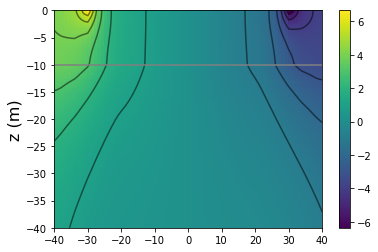

In [441]:
Vplt = (Pc * V).reshape(x.size, z.size, order="F")/10
c = plt.pcolor(xplt, zplt, Vplt, cmap="viridis")
plt.plot(
            [xplt.min(), xplt.max()],
            -h * np.r_[1.0, 1],
            color=[0.5, 0.5, 0.5],
            linewidth=1.5,
        )
plt.contour(xplt, zplt, np.abs(Vplt), colors="k", alpha=0.5)
plt.ylabel("z (m)", fontsize=16)
clim = np.r_[-15.0, 15.0]
clabel = "Potential (V)"
plt.colorbar(c)

([<matplotlib.lines.Line2D at 0x1c6ffae7a88>],
 [<matplotlib.lines.Line2D at 0x1c6ffaea048>])

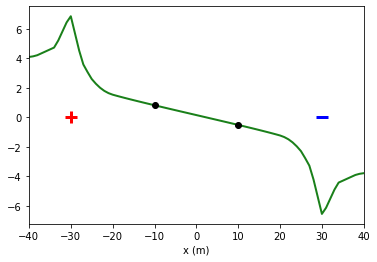

In [452]:
plt.plot(x,Vplt[:,-1],color=[0.1, 0.5, 0.1], linewidth=2)
plt.plot(A, 0, "+", markersize=12, markeredgewidth=3, color=[1.0, 0.0, 0])
plt.plot(B, 0, "_", markersize=12, markeredgewidth=3, color=[0.0, 0.0, 1.0])
plt.xlabel("Potential, (V)")
plt.xlabel("x (m)")
plt.xlim([x.min(), x.max()])

Vobs=Vplt.reshape(-1,)
#VM = 4.5E-01
# VN = -4.5E-01
VM = Vplt[pltgrid[:81,0]==M,-1]
VN = Vplt[pltgrid[:81,0]==N,-1]
plt.plot(M,VM,'ko'), plt.plot(N,VN,'ko')

In [443]:
ex = ex.reshape(x.size, z.size, order="F")
ez = ez.reshape(x.size, z.size, order="F")

e = np.sqrt(ex ** 2.0 + ez ** 2.0)

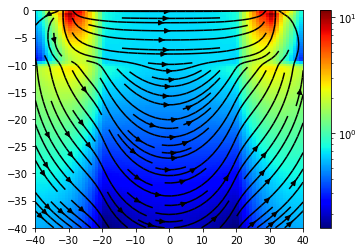

In [448]:
plt.streamplot(x,z,ex.T,ez.T,color='k')
d = plt.pcolor(xplt, zplt, e, cmap="jet",norm=LogNorm())
plt.colorbar(d)
clim = np.r_[3e-3, 1e1]
clabel = "Electric Field (V/m)"

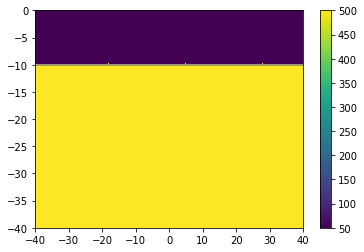

In [445]:
model = rho2 * np.ones(pltgrid.shape[0])
model[pltgrid[:, 1] >= -h] = rho1
#model[pltgrid[:, 1] >= -0.5*h] = 250
model = model.reshape(x.size, z.size, order="F")
cb = plt.pcolor(xplt, zplt, model)
plt.plot(
    [xplt.min(), xplt.max()],
    -h * np.r_[1.0, 1],
    color=[0.5, 0.5, 0.5],
    linewidth=1.5,
)

plt.colorbar()
clim = [rhomin, rhomax]
clabel = "Resistivity ($\Omega$m)"

In [453]:
#VM = 4.5E-01
#VN = -4.5E-01
rho_app = rho_a(VM, VN, A, B, M, N)
print("apparent resistivity: ", rho_app)

apparent resistivity:  [167.52403801]
